In [ ]:
#implementacja sieci na podstawie źródła : https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
def ssim_loss(y_true, y_pred):
  return 1.-tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03) + 1./tf.image.psnr(y_true, y_pred, max_val=1)

# model dyskryminatora
def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	#rozmiar wejściowy obrazu
	in_src_image = Input(shape=image_shape)
	# rozmiar docelowy obrazu
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model
 
# blok kodera
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	
	init = RandomNormal(stddev=0.02)
 
	g = Conv2D(n_filters, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
#blok dekodera
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	
	init = RandomNormal(stddev=0.02)
 
	g = Conv2DTranspose(n_filters, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 
	g = BatchNormalization()(g, training=True)
 
	if dropout:
		g = Dropout(0.5)(g, training=True)
	
	g = Concatenate()([g, skip_in])
 
	g = Activation('relu')(g)
	return g
 
def define_generator(image_shape=(256,256,3)):\

	init = RandomNormal(stddev=0.02)
 
	in_image = Input(shape=image_shape)
	# bloki kodujące
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
 
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# bloki dekodujące
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Wartstwa wyjściowa
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('sigmoid')(g)
 
	model = Model(in_image, out_image)
	return model
 
 
def define_gan(g_model, d_model, image_shape):
	
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	in_src = Input(shape=image_shape)
 
	gen_out = g_model(in_src)
 
	dis_out = d_model([in_src, gen_out])
 
	model = Model(in_src, [dis_out, gen_out])
 
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights=[1,100])
	return model

def load_real_samples():
  start_loading = 0
  end_loading = 1195
  imageNoise = []
  for i in range(start_loading, end_loading):
    image = cv2.imread(f'/content/drive/MyDrive/baza/database/reflects/im{i}.jpg')
    if type(image) is not type(None):
      imageNoise.append(image)
  imageNoise = np.array(imageNoise, dtype='object')
  #image without reflects
  imageClear = []
  for i in range(start_loading, end_loading):
    image = cv2.imread(f'/content/drive/MyDrive/baza/database/clear/im{i}.jpg')
    if type(image) is not type(None):
      imageClear.append(image)
  imageClear = np.array(imageClear, dtype='object')

  imageNoise = imageNoise.astype('float32')
  imageClear = imageClear.astype('float32')
  imageNoise = imageNoise / 255.
  imageClear = imageClear / 255.
  return (imageNoise, imageClear)

def generate_real_samples(dataset, n_samples, patch_shape):

	trainA, trainB = dataset
	
	ix = randint(0, trainA.shape[0], n_samples)
 
	X1, X2 = trainA[ix], trainB[ix]
	
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y
 

def generate_fake_samples(g_model, samples, patch_shape):
	
	X = g_model.predict(samples)
 
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y
 

def summarize_performance(step, g_model, dataset, n_samples=3):
	
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
 
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
 
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
 
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
#pix2pix model training
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=16):

	n_patch = d_model.output_shape[1]
	
	trainA, trainB = dataset
	
	bat_per_epo = int(len(trainA) / n_batch)
 
	n_steps = bat_per_epo * n_epochs;print(f'This -> {n_steps}')
  #print(f'This -> {n_steps}')
	# manually enumerate epochs
	for i in range(n_steps):
		#losowy wektor danych rzeczywistych
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# wektor danych fałszywych, generowanych przez generator
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		#aktualizacja dyskryminatora dla danych rzeczywistych
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		#aktualizacja dyskryminatora dla faksyfikatów
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# aktualizacja generatora z nowymi wagami
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)
 
#wczytanie danych
dataset = load_real_samples()
print('Loaded', dataset[0].shape, dataset[1].shape)

image_shape = dataset[0].shape[1:]
#wywołanie modeli
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)

#trening sieci
train(d_model, g_model, gan_model, dataset)

Loaded (1195, 256, 256, 3) (1195, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>2415, d1[0.066] d2[0.132] g[8.756]
>2416, d1[0.102] d2[0.126] g[9.729]
>2417, d1[0.043] d2[0.205] g[8.811]
>2418, d1[0.142] d2[0.080] g[9.785]
>2419, d1[0.051] d2[0.119] g[8.243]
>2420, d1[0.085] d2[0.074] g[11.465]
>2421, d1[0.030] d2[0.092] g[9.379]
>2422, d1[0.039] d2[0.156] g[9.087]
>2423, d1[0.025] d2[0.107] g[9.568]
>2424, d1[0.075] d2[0.055] g[9.997]
>2425, d1[0.025] d2[0.035] g[10.719]
>2426, d1[0.019] d2[0.083] g[9.091]
>2427, d1[0.017] d2[0.036] g[10.072]
>2428, d1[0.043] d2[0.039] g[11.468]
>2429, d1[0.019] d2[0.043] g[10.636]
>2430, d1[0.014] d2[0.056] g[9.503]
>2431, d1[0.020] d2[0.057] g[10.124]
>2432, d1[0.017] d2[0.356] g[9.739]
>2433, d1[1.370] d2[0.059] g[9.176]
>2434, d1[0.887] d2[0.153] g[7.934]
>2435, d1[0.292] d2[0.170] g[8.339]
>2436, d1[0.129] d2[0.531] g[8.354]
>2437, d1[0.207] d2[0.447] g[8.694]
>2438, d1[0.453] d2[0.263] g[8.881]
>2439, d1[0.572] d2[0.369] g[8.231]
>2440, d1[0.331] d2[0.227] g[7.830]
>2441, 

In [ ]:
tf.keras.models.save_model( g_model, 'drive/MyDrive/model/unet_resnet/g_ssim.h5' )

In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/model/unet_resnet/GAN_ssim.h5')

In [ ]:
#dane testowe z rozbłyskami rzeczywistymi
import os
images = []
for image in os.listdir('drive/MyDrive/baza/test_base/true_image_test/'):
  images.append(cv2.imread(f'drive/MyDrive/baza/test_base/true_image_test/{image}'))
images = np.array(images, dtype='object').astype('float32') / 255.


In [ ]:
prediction = g_model.predict(images)

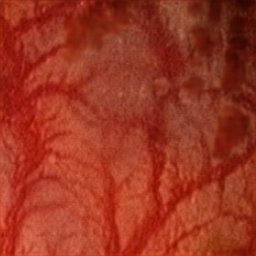

In [ ]:
cv2_imshow(prediction[8]*255)

In [ ]:
pred = model(images)

In [ ]:
pred = np.array(pred, dtype='object')
pred.shape

(10, 256, 256, 3)

In [ ]:
pred_2 = pred - pred.min()
pred_2 = pred_2 * (255./pred_2.max())

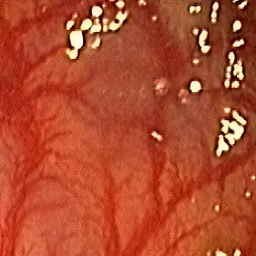

In [ ]:
cv2_imshow(images[8]
           )

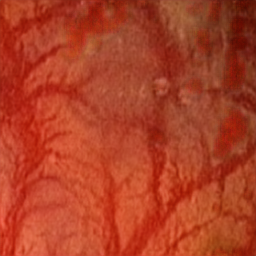

In [ ]:
cv2_imshow(pred_2[8])